In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch

import os


from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score#, BinaryROC

from sklearn.model_selection import train_test_split


from lnn_model import JetParticleDataset, BinaryClassificationLTC
from utils import count_parameters, plot_metrics, plot_ROC, calculate_rocs

from time import time
import gc

In [2]:
print('Preparing data...')
start = time()
        
file_path = '/home/asugu/work/part/event_data_tt_pad16_6.pkl'#750k_bbjj.pkl'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)

del event_data
gc.collect()


Preparing data...


20

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  
#os.environ['TORCH_USE_CUDA_DSA'] = '1'
#os.environ['TORCH_SHOW_CPP_STACKTRACES'] = '1'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(device)


batch_size = 2048
n_epochs = 2
learning_rate = 0.01

in_features = 8
out_features = 1
hidden_units = 8
sparsity = 0.3
N = 64  # Length of the time-series  do i need this

cuda:0


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['flav'])

train_dataset = JetParticleDataset(train_df, device=device)
test_dataset = JetParticleDataset(test_df, device=device)

print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)      # add workers
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)    

print(len(test_dataloader))


553229
1


In [5]:
del df, train_df, test_df, train_dataset, test_dataset
gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 10.982752084732056 seconds.


alloc!
+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     ltc_cell.rnn_cell.gleak     |     8      |
|     ltc_cell.rnn_cell.vleak     |     8      |
|       ltc_cell.rnn_cell.cm      |     8      |
|     ltc_cell.rnn_cell.sigma     |     64     |
|       ltc_cell.rnn_cell.mu      |     64     |
|       ltc_cell.rnn_cell.w       |     64     |
|      ltc_cell.rnn_cell.erev     |     64     |
| ltc_cell.rnn_cell.sensory_sigma |     64     |
|   ltc_cell.rnn_cell.sensory_mu  |     64     |
|   ltc_cell.rnn_cell.sensory_w   |     64     |
|  ltc_cell.rnn_cell.sensory_erev |     64     |
|    ltc_cell.rnn_cell.input_w    |     8      |
|    ltc_cell.rnn_cell.input_b    |     8      |
|    ltc_cell.rnn_cell.output_w   |     1      |
|    ltc_cell.rnn_cell.output_b   |     1      |
|           fc_1.weight           |    128     |
|            fc_1.bias            |     8      |
|           f

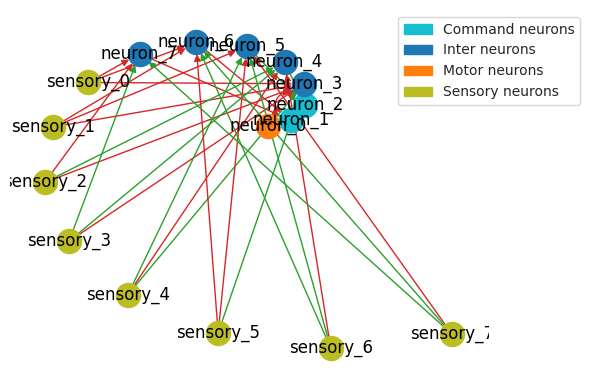

In [6]:

model = BinaryClassificationLTC(in_features,units=hidden_units, sparsity=sparsity)
count_parameters(model)

model.print_model()
#model= nn.DataParallel(model,device_ids = [0, 1])
##################################################### Loss and Optimizer Settings #####################################################

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


Learning rate was set to 0.01000.


  0%|          | 0/270 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

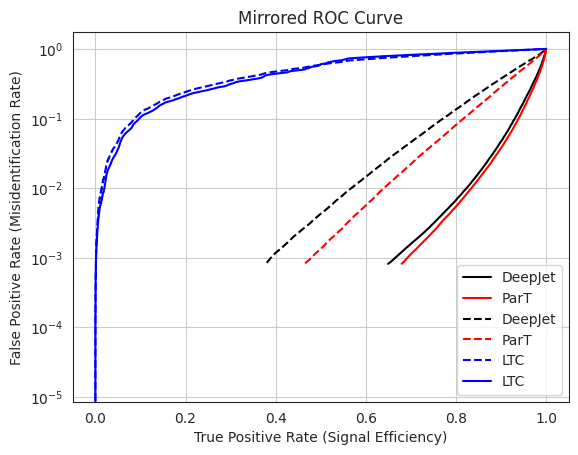

In [7]:
epoch_train_loss = []
epoch_train_accuracy = []
epoch_train_auc = []
epoch_train_f1 = []
epoch_val_loss = []
epoch_val_accuracy = []
epoch_val_auc = []
epoch_val_f1 = []

acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []
   
    


    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_particle_inputs, batch_labels, _ in tqdm(train_dataloader): 

        particle_inputs = batch_particle_inputs.transpose(1,2)
        train_label = batch_labels
    
        
        optimizer.zero_grad()
        train_pred = model(particle_inputs, states=None)   # removed _
     
        train_pred = train_pred.squeeze()


        loss = criterion(train_pred, train_label)
    
        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()
    

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())


    #scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_particle_inputs, val_labels, flavor in test_dataloader: 

            val_particle_inputs = val_particle_inputs.transpose(1,2)
            val_preds = model(val_particle_inputs, states=None) # removed _
            val_preds = val_preds.squeeze()

            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())


           
            
            
            c_fpr, c_tpr, l_fpr, l_tpr = calculate_rocs(val_preds, val_labels, flavor)
       
     
    plot_ROC(c_fpr.cpu().numpy(),c_tpr.cpu().numpy(), l_fpr.cpu().numpy(),l_tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_{i_epoch}')

    epoch_val_loss.append(sum(val_losses) / len(val_losses))
    epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
    epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
    epoch_val_f1.append(sum(val_f1s) / len(val_f1s))

    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))

    plot_metrics(np.arange(i_epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch + 1}/{n_epochs}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch + 1}/{n_epochs}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')

    torch.cuda.empty_cache()
    del loss, val_loss, train_pred, val_preds
    del train_losses, train_accuracies, train_aucs, train_f1s, val_losses, val_accuracies, val_aucs, val_f1s
    gc.collect()
    
#keys = ['train_losses', 'train_accuracies', 'train_aucs', 'val_losses', 'val_accuracies', 'val_aucs']
#values = [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs]
#dict_metrics = {keys[i]: values[i] for i in range(len(keys))}